In [53]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT

In [54]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [55]:
import wandb
wandb.login()

True

In [57]:
image_size = 128
batch_size = 64
train_transform = transforms.Compose([
    # transforms.RandomApply([
    #     transforms.RandomAffine(
    #         degrees=15,          # 小角度旋轉
    #         translate=(0.1, 0.1),# 平移最多 10%
    #         scale=(0.9, 1.1),    # 縮放 +/- 10%
    #         shear=10             # 仿射變形
    #     )
    # ], p=0.2),
    # transforms.RandomApply([
    #     transforms.ColorJitter(brightness=0.2, contrast=0.2)
    # ], p=0.2),
    transforms.Resize((image_size, image_size)),
    # transforms.RandomApply([
    #     transforms.ColorJitter(contrast=0.25, brightness=0.5)
    # ], p=0.8), 
    # transforms.RandomApply([
    #     transforms.GaussianBlur(kernel_size=3)
    # ], p=0.8),  
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: (x - x.mean()) / (x.std() + 1e-8))
])
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: (x - x.mean()) / (x.std() + 1e-8))
])
train_dataset = Thyroid_Dataset("finetune_train_DDTI_v3(0.3).csv", transform = train_transform, return_from_dataset = True, crop_DDTI = True)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = Thyroid_Dataset("finetune_test_DDTI_v3(0.3).csv", transform = test_transform, return_from_dataset = True, crop_DDTI = True, histo_match = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)
image, mask, seg_type, from_dataset = next(iter(train_dataloader))
image = image
mask = mask

In [58]:
print(len(train_dataloader), len(test_dataloader))

3 7


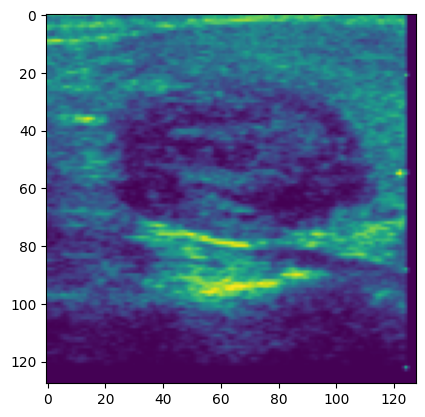

In [59]:
plt.imshow(image[10][0])

In [60]:
def train(dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, seg_type, from_dataset in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)

        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]
        

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)


        
        loss = nodule_loss
        IOU = IOU_score(nodule_output, nodule_mask) 

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(nodule_output, nodule_mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn_nodule, loss_fn_gland, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, seg_type, from_dataset in tqdm(dataloader):
        image, mask, seg_type = image.to(device), mask.to(device), seg_type.to(device)
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :][seg_type==1]
        nodule_mask = mask[seg_type==1]


        DDTI_nodule_output = nodule_output[from_dataset==1]

        DDTI_nodule_mask = nodule_mask[from_dataset==1]
        

        nodule_loss = loss_fn_nodule(nodule_output, nodule_mask)
        
        IOU = IOU_score(nodule_output, nodule_mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(nodule_output, nodule_mask)
    

        total_loss += nodule_loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


    

In [63]:
epochs = 50
lr = 0.01
project = "thyroid"
name="PMFSNet_finetune_baseline_v3(0.3)_crop"
# name = "PMFSNet_baseline_v4(0.9)"
# name = "test"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [64]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.01, epochs : 50, batch size : 64


In [65]:
inference_name = "PMFSNet_crop_DDTI_standardization_aug_colorjitter(contrast_0.25_brightness_0.5)(0.5)_gaussianblur_3(0.5)_for_finetune"
# # model = HarDMSEG(in_channels = 1)
model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# # model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [66]:
# loss_fn = DiceLoss()
loss_fn_nodule = StructureLoss()
loss_fn_gland = StructureLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [67]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn_nodule, loss_fn_gland, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


C:\Users\oplab\anaconda3\envs\thyroid\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))

00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.38it/s]

train loss : 0.9525916576385498, train IOU : 0.4860108296076457, train DICE : 0.6633650859196981



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.86it/s]

val loss : 2.248464720589774, val IOU : 0.22950161567756108, val DICE : 0.3700410383088248
epoch : 1



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.44it/s]

train loss : 0.6477572917938232, train IOU : 0.5961222449938456, train DICE : 0.7326641877492269



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.27it/s]

val loss : 5.42002500806536, val IOU : 0.18631451257637568, val DICE : 0.31511175632476807
epoch : 2



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.64it/s]

train loss : 0.5663564205169678, train IOU : 0.6449073751767477, train DICE : 0.7577023506164551



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.92it/s]

val loss : 4.367950371333531, val IOU : 0.1959345234291894, val DICE : 0.3325848749705723
epoch : 3



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.68it/s]

train loss : 0.5065242648124695, train IOU : 0.6887643138567606, train DICE : 0.7863020300865173



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.80it/s]

val loss : 3.7981951236724854, val IOU : 0.19682174921035767, val DICE : 0.3344138605254037
epoch : 4



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.76it/s]

train loss : 0.46250558892885846, train IOU : 0.7210308313369751, train DICE : 0.8113692402839661



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.73it/s]

val loss : 3.57944985798427, val IOU : 0.2084920917238508, val DICE : 0.3500104546546936
epoch : 5



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.63it/s]

train loss : 0.4189206858476003, train IOU : 0.7464240193367004, train DICE : 0.8349355459213257



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.71it/s]

val loss : 3.192259822572981, val IOU : 0.23431761775697982, val DICE : 0.38592155490602764
epoch : 6



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.63it/s]

train loss : 0.3739810287952423, train IOU : 0.7753643194834391, train DICE : 0.8589169383049011



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.21it/s]

val loss : 1.6750369242259435, val IOU : 0.34767469338008333, val DICE : 0.5111941354615348
epoch : 7



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.62it/s]

train loss : 0.3494730492432912, train IOU : 0.7951590418815613, train DICE : 0.8720121582349142



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.74it/s]

val loss : 1.6916361876896449, val IOU : 0.34548877818243845, val DICE : 0.5147084508623395
epoch : 8



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.78it/s]

train loss : 0.3187822103500366, train IOU : 0.8025646805763245, train DICE : 0.8837801019350687



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.76it/s]

val loss : 1.8032883065087455, val IOU : 0.32812926173210144, val DICE : 0.4979756900242397
epoch : 9



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.03it/s]

train loss : 0.2813788056373596, train IOU : 0.8332339723904928, train DICE : 0.9021105170249939



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.02it/s]

val loss : 0.9400128637041364, val IOU : 0.4853135645389557, val DICE : 0.6527698380606515
epoch : 10



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.64it/s]

train loss : 0.2571450024843216, train IOU : 0.8536714514096578, train DICE : 0.9130743543306986



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.90it/s]

val loss : 0.9554985931941441, val IOU : 0.48870435782841276, val DICE : 0.6581904462405613
epoch : 11



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.69it/s]

train loss : 0.2338110307852427, train IOU : 0.8605226476987203, train DICE : 0.9197831153869629



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.68it/s]

val loss : 0.8624482836042132, val IOU : 0.5188804183687482, val DICE : 0.6929982645171029
epoch : 12



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.75it/s]

train loss : 0.21297789613405863, train IOU : 0.8802927335103353, train DICE : 0.9296396772066752



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.27it/s]

val loss : 0.7694701978138515, val IOU : 0.5549706731523786, val DICE : 0.7211915680340358
epoch : 13



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.66it/s]

train loss : 0.21635213991006216, train IOU : 0.8759516676266988, train DICE : 0.9301197528839111



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.08it/s]

val loss : 0.7592147929327828, val IOU : 0.5571132983480181, val DICE : 0.7256639429501125
epoch : 14



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.84it/s]

train loss : 0.19977350533008575, train IOU : 0.8788097898165385, train DICE : 0.933571437994639



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.28it/s]

val loss : 0.8057857581547329, val IOU : 0.5427455306053162, val DICE : 0.7203655328069415
epoch : 15



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.66it/s]

train loss : 0.1768602579832077, train IOU : 0.9001736243565878, train DICE : 0.9449036717414856



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.99it/s]

val loss : 0.7878988129752023, val IOU : 0.5651907665388924, val DICE : 0.721353394644601
epoch : 16



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.76it/s]

train loss : 0.16715897619724274, train IOU : 0.9025473594665527, train DICE : 0.9473858078320821



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.23it/s]

val loss : 0.8006424648421151, val IOU : 0.5594577278409686, val DICE : 0.7272959692137582
epoch : 17



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.68it/s]

train loss : 0.15435642500718436, train IOU : 0.9094858169555664, train DICE : 0.9506670832633972



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.72it/s]

val loss : 0.8699507543018886, val IOU : 0.5490737812859672, val DICE : 0.7088346907070705
epoch : 18



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.80it/s]

train loss : 0.15292133390903473, train IOU : 0.9142260551452637, train DICE : 0.9525580604871114



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.17it/s]

val loss : 0.8039936423301697, val IOU : 0.5708970257214138, val DICE : 0.7379863262176514
epoch : 19



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.99it/s]

train loss : 0.13868693013985953, train IOU : 0.9198042352994283, train DICE : 0.956976314385732



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.93it/s]

val loss : 0.8261904631342206, val IOU : 0.5658747042928424, val DICE : 0.7329894730022976
epoch : 20



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.67it/s]

train loss : 0.13503489394982657, train IOU : 0.923621654510498, train DICE : 0.9576927820841471



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.30it/s]

val loss : 0.8686633450644357, val IOU : 0.5566491910389492, val DICE : 0.7244490044457572
epoch : 21



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.02it/s]

train loss : 0.12618760764598846, train IOU : 0.9276274045308431, train DICE : 0.960320770740509



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.90it/s]

val loss : 0.8726476175444466, val IOU : 0.5617367454937526, val DICE : 0.7281465445246015
epoch : 22



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.78it/s]

train loss : 0.1218622624874115, train IOU : 0.9328346649805704, train DICE : 0.9624525109926859



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.58it/s]

val loss : 0.8940603562763759, val IOU : 0.5559544733592442, val DICE : 0.727150389126369
epoch : 23



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.83it/s]

train loss : 0.11317795515060425, train IOU : 0.9342212478319804, train DICE : 0.9650016824404398



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.69it/s]

val loss : 0.9255708711487907, val IOU : 0.5580455320222037, val DICE : 0.7185482723372323
epoch : 24



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.78it/s]

train loss : 0.11267366260290146, train IOU : 0.9362000028292338, train DICE : 0.9648984869321188



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.69it/s]

val loss : 0.9211894358907428, val IOU : 0.5583915540150234, val DICE : 0.7301901749202183
epoch : 25



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.77it/s]

train loss : 0.1112562542160352, train IOU : 0.9383576711018881, train DICE : 0.9663663506507874



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.73it/s]

val loss : 0.912978504385267, val IOU : 0.5659256407192775, val DICE : 0.7289317165102277
epoch : 26



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.82it/s]

train loss : 0.10535550365845363, train IOU : 0.9376108249028524, train DICE : 0.9674917260805765



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.42it/s]

val loss : 0.9112970573561532, val IOU : 0.5635176386151995, val DICE : 0.7340706501688276
epoch : 27



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.17it/s]

train loss : 0.10019843777020772, train IOU : 0.9446329275767008, train DICE : 0.9696825742721558



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.69it/s]

val loss : 0.9344329578535897, val IOU : 0.5656835351671491, val DICE : 0.7327512502670288
epoch : 28



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.81it/s]

train loss : 0.09654215971628825, train IOU : 0.9466660221417745, train DICE : 0.9704586466153463



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.73it/s]

val loss : 0.9431983402797154, val IOU : 0.5641357132366726, val DICE : 0.7291273730141776
epoch : 29



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.65it/s]

train loss : 0.09302252531051636, train IOU : 0.9455884695053101, train DICE : 0.9712234735488892



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.92it/s]

val loss : 0.9498158352715629, val IOU : 0.5583186319896153, val DICE : 0.7284675751413617
epoch : 30



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.62it/s]

train loss : 0.10376424590746562, train IOU : 0.9429980913798014, train DICE : 0.9691567818323771



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.31it/s]

val loss : 0.9478176151003156, val IOU : 0.5637315256255013, val DICE : 0.7323734589985439
epoch : 31



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.62it/s]

train loss : 0.10398306945959727, train IOU : 0.9391632676124573, train DICE : 0.9673107266426086



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.76it/s]

val loss : 0.9363483020237514, val IOU : 0.5675050956862313, val DICE : 0.7345156584467206
epoch : 32



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.08it/s]

train loss : 0.09282493591308594, train IOU : 0.9443712035814921, train DICE : 0.9707348148028055



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.80it/s]

val loss : 0.9720192040715899, val IOU : 0.5592713696616036, val DICE : 0.7271554980959211
epoch : 33



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.93it/s]

train loss : 0.08640972276528676, train IOU : 0.9541958967844645, train DICE : 0.974034587542216



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.78it/s]

val loss : 0.9877037576266697, val IOU : 0.5571900606155396, val DICE : 0.7233856831278119
epoch : 34



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.70it/s]

train loss : 0.08991446594397227, train IOU : 0.9497576355934143, train DICE : 0.972496747970581



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.80it/s]

val loss : 0.9500141569546291, val IOU : 0.5646281157221112, val DICE : 0.7332221269607544
epoch : 35



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.73it/s]

train loss : 0.08270858476559322, train IOU : 0.9528918663660685, train DICE : 0.9741060733795166



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.79it/s]

val loss : 0.9583281108311245, val IOU : 0.5623432738440377, val DICE : 0.7329828568867275
epoch : 36



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.80it/s]

train loss : 0.0886189416050911, train IOU : 0.9519076546033224, train DICE : 0.9730803569157919



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.65it/s]

val loss : 0.9956690243312291, val IOU : 0.5573687042508807, val DICE : 0.7267232281821114
epoch : 37



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.09it/s]

train loss : 0.07830215245485306, train IOU : 0.9607585668563843, train DICE : 0.9765175779660543



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.81it/s]

val loss : 0.9807501946176801, val IOU : 0.5618652190480914, val DICE : 0.7301634550094604
epoch : 38



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.06it/s]

train loss : 0.08161792904138565, train IOU : 0.9527344306310018, train DICE : 0.974575956662496



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.32it/s]

val loss : 0.9655442152704511, val IOU : 0.5650442838668823, val DICE : 0.7338723114558628
epoch : 39



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.81it/s]

train loss : 0.07810043295224507, train IOU : 0.9562405149141947, train DICE : 0.9754452506701151



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.01it/s]

val loss : 0.9738620689937046, val IOU : 0.5638250282832554, val DICE : 0.7329871909958976
epoch : 40



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.79it/s]

train loss : 0.07655730843544006, train IOU : 0.9606033166249593, train DICE : 0.9765198032061259



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.33it/s]

val loss : 0.9889306000300816, val IOU : 0.561613312789372, val DICE : 0.7309539062636239
epoch : 41



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.71it/s]

train loss : 0.07595301916201909, train IOU : 0.9617889920870463, train DICE : 0.9770650068918864



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.06it/s]

val loss : 0.985923707485199, val IOU : 0.5628685695784432, val DICE : 0.7323784232139587
epoch : 42



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.84it/s]

train loss : 0.07437161356210709, train IOU : 0.9622229735056559, train DICE : 0.9771413405736288



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.77it/s]

val loss : 0.9812349166188922, val IOU : 0.5638298732893807, val DICE : 0.7333990590912955
epoch : 43



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.01it/s]

train loss : 0.07996597389380138, train IOU : 0.9559956590334574, train DICE : 0.9749672015508016



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.77it/s]

val loss : 0.9746759874480111, val IOU : 0.5650413632392883, val DICE : 0.7348022035190037
epoch : 44



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.76it/s]

train loss : 0.0763474628329277, train IOU : 0.9593570828437805, train DICE : 0.9758707086245219



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.18it/s]

val loss : 0.9780633790152413, val IOU : 0.5644040703773499, val DICE : 0.734089698110308
epoch : 45



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.74it/s]

train loss : 0.07615241408348083, train IOU : 0.9595550696055094, train DICE : 0.9761685132980347



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.80it/s]

val loss : 0.9775058967726571, val IOU : 0.564358515398843, val DICE : 0.7343712108475822
epoch : 46



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.79it/s]

train loss : 0.07410287360350291, train IOU : 0.960905392964681, train DICE : 0.9769567648569742



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.74it/s]

val loss : 0.9783578089305333, val IOU : 0.5641545908791679, val DICE : 0.7343161872455052
epoch : 47



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.01it/s]

train loss : 0.07209718227386475, train IOU : 0.9631813764572144, train DICE : 0.9776866436004639



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.19it/s]

val loss : 0.9793523039136615, val IOU : 0.5640501976013184, val DICE : 0.7342432481901986
epoch : 48



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.62it/s]

train loss : 0.07206316292285919, train IOU : 0.9631456931432089, train DICE : 0.9776253501574198



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.78it/s]

val loss : 0.9796675784247262, val IOU : 0.5640183346612113, val DICE : 0.7342468414987836
epoch : 49



00%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.78it/s]

train loss : 0.07223748415708542, train IOU : 0.9629491170247396, train DICE : 0.9776789546012878



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 14.79it/s]

val loss : 0.9797456434794835, val IOU : 0.5641174060957772, val DICE : 0.7343578679221017


Learning Rate,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_DICE,▁▃▃▄▄▅▆▆▆▇▇▇▇▇▇▇████████████████████████
train_IOU,▁▃▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████████████
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_DICE,▂▁▁▁▂▄▄▄▇▇██████████████████████████████
val_IOU,▂▁▁▁▁▄▄▄▆▇██▇███████████████████████████
val_loss,▃█▆▆▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Learning Rate,0
epoch,49
train_DICE,0.97768


In [23]:
inference_name = "PMFSNet_finetune_baseline_v3(0.3)"
# model = HarDMSEG(in_channels = 1)
model = PMFSNet(in_channels = 1, out_channels = 2, dim = "2d")
# model = LightMed(in_channels = 1, out_channels = 1, image_size = image_size)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [24]:
loss_fn_nodule = StructureLoss()
loss_fn_gland = StructureLoss()
total_loss_val, total_IOU_val, total_DICE_val,  = val(test_dataloader, model, loss_fn_nodule, loss_fn_gland, "cpu")
print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")



00%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.04it/s]

val loss : 0.7167810712541852, val IOU : 0.5742447376251221, val DICE : 0.7393667442458016


In [28]:
image, mask, seg_type, from_dataset = next(iter(test_dataloader))
model.to("cpu")
outputs = model(image)
print(outputs.shape)

torch.Size([64, 2, 128, 128])


Text(0.5, 1.0, 'prediction')

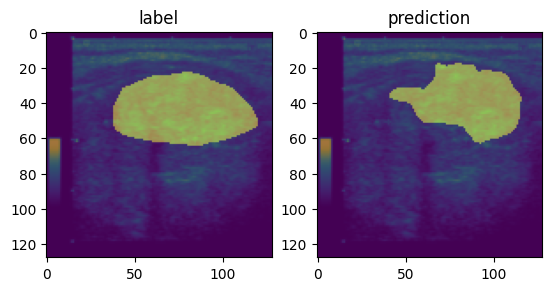

In [31]:
index = 0
plt.subplot(1,2,1)
plt.imshow(image[index][0])
plt.imshow(mask[index][0], alpha = 0.5)
plt.title("label")

outputs = outputs>0.5
plt.subplot(1,2,2)
plt.imshow(image[index][0])
plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
plt.title("prediction")

Text(0.5, 1.0, 'prediction')

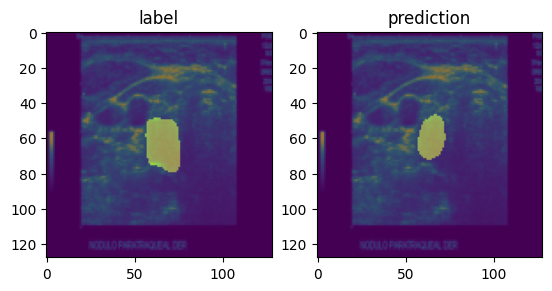

In [52]:
index = 18
plt.subplot(1,2,1)
plt.imshow(image[index][0])
plt.imshow(mask[index][0], alpha = 0.5)
plt.title("label")

outputs = outputs>0.5
plt.subplot(1,2,2)
plt.imshow(image[index][0])
plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
plt.title("prediction")